In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pop64752","key":"d36844537e82581497d5219234508fc4"}'}

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d mbornoe/lisa-traffic-light-dataset

100% 4.21G/4.21G [00:33<00:00, 211MB/s]
100% 4.21G/4.21G [00:33<00:00, 134MB/s]


In [ ]:
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

# Install dependencies from requirements.txt
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 16413, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 16413 (delta 0), reused 3 (delta 0), pack-reused 16408
Receiving objects: 100% (16413/16413), 14.90 MiB | 18.44 MiB/s, done.
Resolving deltas: 100% (11265/11265), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.0/715.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


In [ ]:
!mkdir /content/Dataset
!unzip -q /content/lisa-traffic-light-dataset.zip -d /content/Dataset



Class Distribution across all sequences:
stop           25936
go             23777
stopLeft        5027
warning         1411
goLeft          1240
goForward        205
warningLeft       53
Name: Annotation tag, dtype: int64


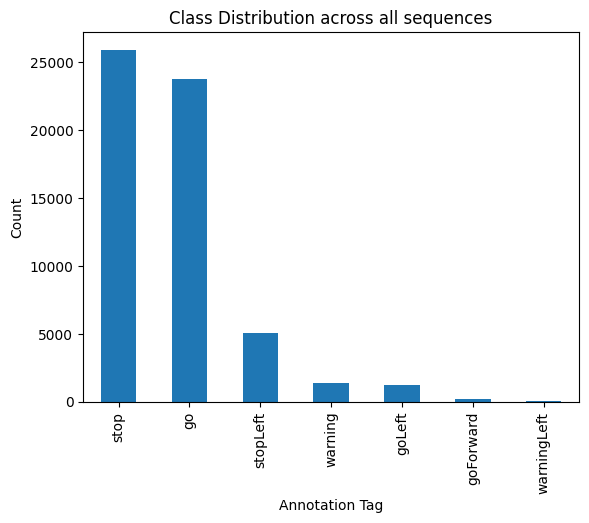

In [ ]:
import os
import pandas as pd

base_dataset_path = '/content/Dataset'
annotations_base_path = os.path.join(base_dataset_path, 'Annotations', 'Annotations')
sequences = ['daySequence1', 'daySequence2', 'nightSequence1', 'nightSequence2']

all_annotations = pd.DataFrame()

for sequence in sequences:
    sequence_path = os.path.join(annotations_base_path, sequence)

    for file in os.listdir(sequence_path):
        if file.endswith('BOX.csv'):
            annotations_csv_path = os.path.join(sequence_path, file)
            annotations_df = pd.read_csv(annotations_csv_path, delimiter=';')
            all_annotations = pd.concat([all_annotations, annotations_df], ignore_index=True)

class_distribution = all_annotations['Annotation tag'].value_counts()

# Print the class distribution
print("Class Distribution across all sequences:")
print(class_distribution)

import matplotlib.pyplot as plt

class_distribution.plot(kind='bar')
plt.title('Class Distribution across all sequences')
plt.xlabel('Annotation Tag')
plt.ylabel('Count')
plt.show()


In [ ]:
!pip install ImageHash


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 2.8 MB/s eta 0:00:00


In [ ]:
import os
from PIL import Image
import imagehash
import numpy as np

def remove_near_duplicates_batch(base_dir, threshold=5, batch_size=1000, remove=False):
    """
    Remove near-duplicate images from a dataset based on perceptual hashing in batches.

    Parameters:
        base_dir (str): Directory containing images to check for duplicates.
        threshold (int): The difference threshold between hashes to consider images as duplicates.
        batch_size (int): Number of images to process in each batch.
        remove (bool): If True, remove the near-duplicate images. Otherwise, just list them.
    """
    all_files = []
    for subdir, dirs, files in os.walk(base_dir):
        for filename in files:
            if filename.lower().endswith('.jpg'):
                filepath = os.path.join(subdir, filename)
                all_files.append(filepath)

    total_files = len(all_files)
    num_batches = np.ceil(total_files / batch_size).astype(int)

    for batch in range(num_batches):
        print(f"Processing batch {batch+1} of {num_batches}")
        batch_files = all_files[batch*batch_size : (batch+1)*batch_size]
        hashes = {}
        duplicates = []

        for filepath in batch_files:
            img_hash = imagehash.phash(Image.open(filepath))

            duplicate = False
            for existing_hash in hashes.keys():
                if abs(img_hash - existing_hash) <= threshold:
                    duplicate = True
                    duplicates.append((hashes[existing_hash], filepath))
                    break

            if not duplicate:
                hashes[img_hash] = filepath

        # remove duplicates in this batch
        for original, duplicate in duplicates:
            print(f"Original: {original}, Duplicate: {duplicate}")
            if remove:
                os.remove(duplicate)
                print(f"Removed {duplicate}")


base_dir = '/content/Dataset'
remove_near_duplicates_batch(base_dir, threshold=5, batch_size=1000, remove=True)


Processing batch 1 of 45


KeyboardInterrupt: 

In [ ]:
import os
import pandas as pd

base_dataset_path = '/content/Dataset'
annotations_base_path = os.path.join(base_dataset_path, 'Annotations', 'Annotations')
output_base_path = '/content/yolo_labels'

class_mapping = {'stop': 0, 'warning': 1, 'go': 2}

# Function to convert a single annotation entry to YOLO format
def convert_annotation(row, img_width, img_height):
    x_center = ((row['Upper left corner X'] + row['Lower right corner X']) / 2) / img_width
    y_center = ((row['Upper left corner Y'] + row['Lower right corner Y']) / 2) / img_height
    width = (row['Lower right corner X'] - row['Upper left corner X']) / img_width
    height = (row['Lower right corner Y'] - row['Upper left corner Y']) / img_height
    class_id = class_mapping[row['Annotation tag']]

    return f"{class_id} {x_center} {y_center} {width} {height}"

# Function to process all annotations in a directory
def process_directory(directory, output_directory, img_width, img_height):
    for file in os.listdir(directory):
        if file.endswith('BOX.csv'):
            annotations_csv_path = os.path.join(directory, file)
            annotations_df = pd.read_csv(annotations_csv_path, delimiter=';')

            # Group by filename to handle multiple annotations per file
            grouped = annotations_df.groupby('Filename')

            for filename, group in grouped:
                output_filename = os.path.splitext(filename.split('/')[-1])[0] + '.txt'
                output_filepath = os.path.join(output_directory, output_filename)

                os.makedirs(os.path.dirname(output_filepath), exist_ok=True)

                with open(output_filepath, 'w') as f:
                    for _, row in group.iterrows():
                        if row['Annotation tag'] not in class_mapping :
                          continue
                        yolo_annotation = convert_annotation(row, img_width, img_height)
                        f.write(yolo_annotation + '\n')

sequences = ['daySequence1', 'daySequence2', 'nightSequence1', 'nightSequence2']

# Iterate over all annotation directories and process them
for sequence in sequences:
    sequence_path = os.path.join(annotations_base_path, sequence)
    output_dir = os.path.join(output_base_path, sequence)
    os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

    # Process the directory
    process_directory(sequence_path, output_dir, img_width=1280, img_height=960)


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Base paths
dataset_base_path = '/content/Dataset'
annotations_base_path = '/content/yolo_labels'
output_base_path = '/content/yolo_labels'

sequences = ['daySequence1', 'daySequence2', 'nightSequence1', 'nightSequence2']

for phase in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_base_path, f'images/{phase}'), exist_ok=True)
    os.makedirs(os.path.join(output_base_path, f'labels/{phase}'), exist_ok=True)

def copy_files(file_list, source_images, source_labels, dest_images, dest_labels):
    for file in file_list:
        shutil.copy2(os.path.join(source_images, file + '.jpg'), os.path.join(dest_images, file + '.jpg'))
        shutil.copy2(os.path.join(source_labels, file + '.txt'), os.path.join(dest_labels, file + '.txt'))

for sequence in sequences:
    # Adjust paths for the current sequence
    images_base_path = os.path.join(dataset_base_path, sequence,sequence, 'frames')
    annotations_base_path_sequence = os.path.join(annotations_base_path, sequence)

    # Gather image and annotation files, then match them
    image_files = [os.path.splitext(file)[0] for file in os.listdir(images_base_path) if file.endswith('.jpg')]
    annotation_files = [os.path.splitext(file)[0] for file in os.listdir(annotations_base_path_sequence) if file.endswith('.txt')]
    matched_files = list(set(image_files).intersection(annotation_files))

    # Split the matched files into training, validation, and test sets
    train_files, test_files = train_test_split(matched_files, test_size=0.1, random_state=42)
    train_files, val_files = train_test_split(train_files, test_size=0.1667, random_state=42)

    # Copy files for each set
    for phase, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
        dest_images_path = os.path.join(output_base_path, f'images/{phase}', sequence)
        dest_labels_path = os.path.join(output_base_path, f'labels/{phase}', sequence)
        os.makedirs(dest_images_path, exist_ok=True)
        os.makedirs(dest_labels_path, exist_ok=True)
        copy_files(file_list, images_base_path, annotations_base_path_sequence, dest_images_path, dest_labels_path)


In [ ]:
# Train the model
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

!python train.py --img 1280 --batch 12 --epochs 75 --data /content/dataset.yaml --weights yolov5m.pt --cache --hyp /content/hyp.yaml


2024-02-14 22:02:13.996469: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 22:02:13.996524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 22:02:13.997955: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m.pt, cfg=, data=/content/dataset.yaml, hyp=/content/hyp.yaml, epochs=75, batch_size=12, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimi

In [ ]:
import os
!ls /content/yolov5/runs/train/exp3/weights

target_dir = '/content/drive/MyDrive/weights'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)


# coping the best weights to drive
!cp /content/yolov5/runs/train/exp3/weights/best.pt /content/drive/MyDrive/weights1

best.pt  last.pt


In [ ]:
%cd /content/yolov5

!python detect.py --weights /content/weights1.pt --img 1280 --conf 0.25 --source /content/Dataset/daySequence2/daySequence2/frames




Streaming output truncated to the last 5000 lines.
image 1897/6894 /content/Dataset/daySequence2/daySequence2/frames/daySequence2--01896.jpg: 960x1280 1 stop, 35.8ms
image 1898/6894 /content/Dataset/daySequence2/daySequence2/frames/daySequence2--01897.jpg: 960x1280 1 stop, 34.4ms
image 1899/6894 /content/Dataset/daySequence2/daySequence2/frames/daySequence2--01898.jpg: 960x1280 1 stop, 34.9ms
image 1900/6894 /content/Dataset/daySequence2/daySequence2/frames/daySequence2--01899.jpg: 960x1280 1 stop, 35.8ms
image 1901/6894 /content/Dataset/daySequence2/daySequence2/frames/daySequence2--01900.jpg: 960x1280 1 stop, 36.6ms
image 1902/6894 /content/Dataset/daySequence2/daySequence2/frames/daySequence2--01901.jpg: 960x1280 1 stop, 34.4ms
image 1903/6894 /content/Dataset/daySequence2/daySequence2/frames/daySequence2--01902.jpg: 960x1280 1 stop, 35.5ms
image 1904/6894 /content/Dataset/daySequence2/daySequence2/frames/daySequence2--01903.jpg: 960x1280 1 stop, 35.3ms
image 1905/6894 /content/Data

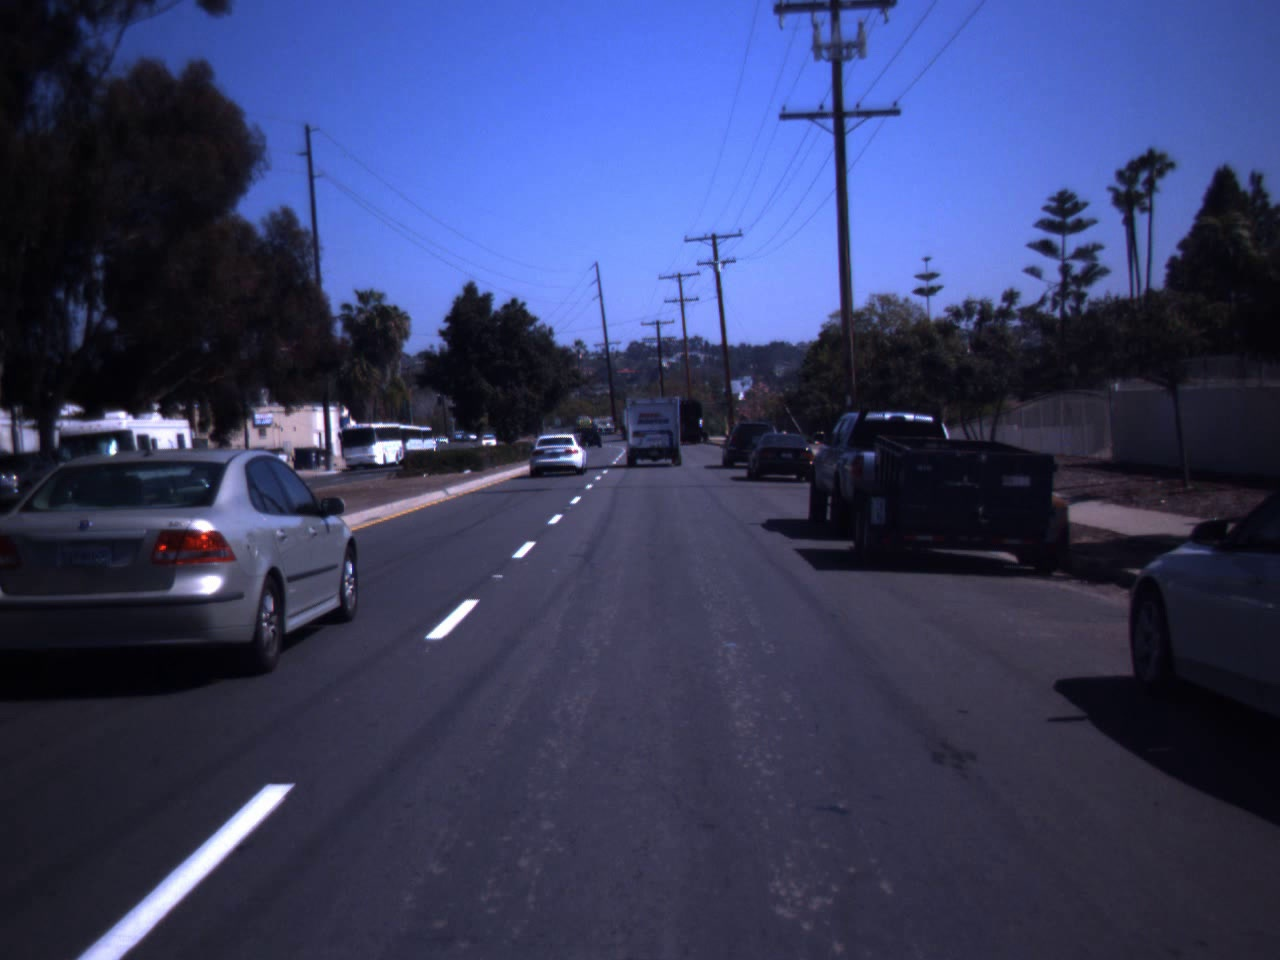

In [ ]:
from IPython.display import Image
import glob

result_images = glob.glob('/content/yolov5/runs/detect/exp3/*.jpg')

if result_images:
    display(Image(filename=result_images[999]))
else:
    print("No detection images found.")


In [ ]:
%cd /content/yolov5
%load_ext tensorboard
%tensorboard --logdir /content/yolov5/runs/train